In [1]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  

In [2]:
def process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    处理图片并计算特征和梯度的加权值donations_values  

    Args:  
        img_path (str): 输入图片的路径  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        tensor: shape (num_classes,) 的 tensor，表示各个类别的donations_values  
    """  
    # 定义预处理步骤  
    test_transform = transforms.Compose([  
        transforms.Resize(512),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 获取设备  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    model = resnet50(weights=model_weights).eval().to(device)  

    # print(f"try to open image, path：{img_path}")  
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
        print(f"跳过非图片文件：{img_path}")  
        return None  

    # 加载图片  
    img_pil = Image.open(img_path)  

    # 预处理图片  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  

    # 定义前向hook  
    def forward_hook(module, inp, outp):  
        feature_map.append(outp)  

    # 定义反向hook  
    def backward_hook(module, inp, outp):  
        grad.append(outp)  

    # 初始化容器  
    feature_map = []  
    grad = []  

    # 注册hook  
    hook_layer = model.layer4[-1]  
    hook_handle = hook_layer.register_forward_hook(forward_hook)  
    grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

    try:  
        # 前向传播  
      
        out = model(input_tensor)  
        cls_idx = torch.argmax(out).item()  
        # 计算预测类别分数  
        score = out[:, cls_idx].sum()  

        # 反向传播  
        model.zero_grad()  
        score.backward(retain_graph=False)  # 减少内存占用  

        # 获取特征和梯度  
        weights = grad[0][0].squeeze(0).mean(dim=(1, 2))  
        mean_values = feature_map[0].squeeze(0).mean(dim=(1, 2))  #GAP(a)

        # 计算加权后的值  
        # donations_values = mean_values * weights  
        donations_values =  mean_values

        return donations_values.detach().cpu()  

    except Exception as e:  
        print(f"处理过程中出现错误：{e}")  
        return None  

    finally:  
        # 删除hook并清理数据  
        hook_handle.remove()  
        grad_hook_handle.remove()  
        feature_map.clear()  
        grad.clear()  

        # 删除GPU上的张量并释放内存  
        if input_tensor.is_cuda:  
            del input_tensor  
            torch.cuda.empty_cache()  

        if 'out' in locals():  
            del out  
        if 'score' in locals():  
            del score

In [3]:
img_path="dataset/波斯猫/1.jpg"
donations_values=process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT)
print(donations_values)
donations_values.size()

tensor([0.0000, 0.0138, 0.0079,  ..., 0.0080, 0.0000, 0.0138])


torch.Size([2048])

In [4]:
import numpy as np  

# 配置PyTorch的内存分配参数，减少内存碎片  
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'  

def process_batch_images(class_path, batch_size=8, device=None):  
    """  
    批量处理一个类别下的所有图片，并返回每张图片的donations_values  

    Args:  
        class_path (str): 类别图片的路径  
        batch_size (int): 批次大小，缺省值为8  
        device (str or torch.device, optional): 设备类型（"cpu" 或 "cuda"），缺省值为 None，会自动检测  

    Returns:  
        list: 包含每张图片的donations_values 的列表  
    """  
    if device is None:  
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    print()
    print("using device:"+str(device))
    print("analyse class:"+str(class_path))
    donations_values_list = []  

    # 获取图片文件路径列表  
    img_paths = [os.path.join(class_path, f) for f in os.listdir(class_path)  
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]  

    # 计算总批次数  
    total_batches = len(img_paths) // batch_size  
    if len(img_paths) % batch_size != 0:  
        total_batches += 1  

    succeed_img = 0
    # 分批次处理图片  
    for batch_idx in range(total_batches):  
        start = batch_idx * batch_size  
        end = min((batch_idx + 1) * batch_size, len(img_paths))  
        batch_paths = img_paths[start:end]  

        batch_features = []  

        # 逐张处理图片以减少内存占用  
        for img_path in batch_paths:  
            try:  
                # 使用process_image_withhooks处理图片  
                donations_value = process_image_withhooks(img_path)  

                if donations_value is not None:  
                    # 添加到批次结果  
                    # print("succeed to process image:"+img_path)
                    succeed_img += 1
                    batch_features.append(donations_value)  

            except Exception as e:  
                print(f"处理 {img_path} 时发生错误：{str(e)}")  
                continue  

        # 如果批次中没有有效的特征，跳过  
        if not batch_features:  
            continue  

        # 将批次的特征拼接到结果列表  
        donations_values_list.extend(batch_features)  

        # 释放当前批次的内存  
        batch_features.clear()  

    print(f"all_imgs : {succeed_img}")
    return donations_values_list


def process_batch_images_with_dict(class_path, batch_size=5, device=None):  
    """  
    批量处理一个类别下的所有图片，并返回每张图片的donations_values列表  

    Args:  
        class_path (str): 类别图片的路径  
        batch_size (int): 批次大小，缺省值为8  
        device (str or torch.device, optional): 设备类型（"cpu" 或 "cuda"），缺省值为 None，会自动检测  

    Returns:  
        dict: 键是img_path，值是对应的donations_value  
    """  
    if device is None:  
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    print("\nusing device:" + str(device))  
    print("analyse class:" + str(class_path))  
    donations_dict = {}  # 使用字典存储结果  

    # 获取图片文件路径列表  
    img_paths = [os.path.join(class_path, f) for f in os.listdir(class_path)  
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]  

    # 计算总批次数  
    total_batches = len(img_paths) // batch_size  
    if len(img_paths) % batch_size != 0:  
        total_batches += 1  

    succeed_img = 0  
    # 分批次处理图片  
    for batch_idx in range(total_batches):  
        start = batch_idx * batch_size  
        end = min((batch_idx + 1) * batch_size, len(img_paths))  
        batch_paths = img_paths[start:end]  

        batch_features = []  

        # 逐张处理图片以减少内存占用  
        for img_path in batch_paths:  
            try:  
                # 使用process_image_withhooks处理图片  
                donations_value = process_image_withhooks(img_path)  

                if donations_value is not None:  
                    #添加到批次结果  
                    # print("succeed to process image:" + img_path)  
                    succeed_img += 1  
                    batch_features.append((img_path, donations_value))  

            except Exception as e:  
                print(f"处理 {img_path} 时发生错误：{str(e)}")  
                continue  

        # 如果批次中没有有效的特征，跳过  
        if not batch_features:  
            continue  

        # 将批次的特征拼接到结果字典  
        for img_path, donations_value in batch_features:  
            donations_dict[img_path] = donations_value  

        # 释放当前批次的内存  
        batch_features.clear()  

    print(f"all_imgs : {succeed_img}")  
    return donations_dict  

In [5]:
# class_path1="dataset/n02105505/" #匈牙利牧羊犬
# class_path2="dataset/n02101006/" #戈登雪达犬
# # class_path3="dataset/n01910747/" #水母
# donations_values_list1 = process_batch_images(class_path1)
# donations_values_list2 = process_batch_images(class_path2)
# # donations_values_list3 = process_batch_images(class_path3)


In [6]:
# class_path1="dataset/n01532829/" #家朱雀
# class_path2="dataset/n01558993/" #蓝鹀
# donations_values_list1 = process_batch_images_with_dict(class_path1)  
# donations_values_list2 = process_batch_images_with_dict(class_path2)


In [7]:
# class_path1="dataset/n01532829/" #家朱雀
# class_path2="dataset/n01558993/" #蓝鹀
class_path1="dataset/n02105505/" #匈牙利牧羊犬
class_path2="dataset/n02101006/" #戈登雪达犬
donations_values_list1 = process_batch_images_with_dict(class_path1)  
donations_values_list2 = process_batch_images_with_dict(class_path2)


using device:cuda
analyse class:dataset/n02105505/
all_imgs : 100

using device:cuda
analyse class:dataset/n02101006/
all_imgs : 100


In [8]:
from sklearn.metrics.pairwise import cosine_similarity  
import numpy as np  

def calculate_intra_class_similarity(donations_values_list):  
    """  
    计算类内相似度  

    Args:  
        donations_values_list (list): 包含一个类别中所有图片的donations_values的列表  

    Returns:  
        float: 类内相似度的平均值  
    """  
    if len(donations_values_list) < 2:  
        return 0.0  # 如果类别中图片少于2张，无法计算相似度  

    # 将tensor列表转换为numpy数组  
    donations_array = np.stack([tensor.numpy() for tensor in donations_values_list])  

    # 计算余弦相似度矩阵  
    similarity_matrix = cosine_similarity(donations_array)  

    # 取上三角部分（忽略对角线）  
    upper_triangle = np.triu(similarity_matrix, k=1)  

    # 计算平均值  
    num_pairs = len(donations_values_list) * (len(donations_values_list) - 1) // 2  
    return np.sum(upper_triangle) / num_pairs 

In [9]:
def calculate_inter_class_similarity(class1_values, class2_values):  
    """  
    计算类间相似度  

    Args:  
        class1_values (list): 类别1的donations_values列表  
        class2_values (list): 类别2的donations_values列表  

    Returns:  
        float: 类间相似度的平均值  
    """  
    if len(class1_values) == 0 or len(class2_values) == 0:  
        return 0.0  # 如果某一类别没有数据，无法计算相似度  

    # 将tensor列表转换为numpy数组  
    class1_array = np.stack([tensor.numpy() for tensor in class1_values])  
    class2_array = np.stack([tensor.numpy() for tensor in class2_values])  

    # 计算余弦相似度矩阵  
    similarity_matrix = cosine_similarity(class1_array, class2_array)  

    # 返回平均值  
    return np.mean(similarity_matrix)

In [10]:
def batch_process_and_analyze(dataset_path,class1,class2):  
    """  
    批量处理图片并计算类内和类间相似度  

    Args:  
        dataset_path (str): 数据集路径，包含两个类别文件夹class1和class2  

    Returns:  
        tuple: (intra_class_similarity_class1, intra_class_similarity_class2, inter_class_similarity)  
    """  
    class1_path = os.path.join(dataset_path, class1)  
    class2_path = os.path.join(dataset_path, class2)  

    # 处理两个类别的图片  
    class1_values = process_batch_images(class1_path)  
    class2_values = process_batch_images(class2_path)  

    # 计算类内相似度  
    intra_class_similarity_class1 = calculate_intra_class_similarity(class1_values)  
    intra_class_similarity_class2 = calculate_intra_class_similarity(class2_values)  

    # 计算类间相似度  
    inter_class_similarity = calculate_inter_class_similarity(class1_values, class2_values)  

    return intra_class_similarity_class1, intra_class_similarity_class2, inter_class_similarity

In [11]:
# dataset_path = "dataset/"  
# intra_class1, intra_class2, inter_class = batch_process_and_analyze(dataset_path,"n01532829/","n01558993/")  
# print()
# print(f"Class1 类内相似度: {intra_class1}")  
# print(f"Class2 类内相似度: {intra_class2}")  
# print(f"Class1 和 Class2 类间相似度: {inter_class}") 

In [12]:
# dataset_path = "dataset/"  
# intra_class1, intra_class2, inter_class = batch_process_and_analyze(dataset_path,"n02105505/","n02108089/")  
# print()
# print(f"Class1 类内相似度: {intra_class1}")  
# print(f"Class2 类内相似度: {intra_class2}")  
# print(f"Class1 和 Class2 类间相似度: {inter_class}") 

In [13]:
# from sklearn.metrics.pairwise import cosine_similarity  
# import numpy as np  

# def analyze_intra_class_similarity(donations_values_list, top_n=20):  
#     """  
#     分析同一类别中所有图片两两之间的余弦相似度，并返回相似度最大的和最小的样本对。  

#     Args:  
#         donations_values_list (list): 包含一个类别中所有图片的donations_values的列表。  
#         top_n (int, optional): 指定要返回的最大和最小的样本对数。默认为20。  

#     Returns:  
#         dict: 一个字典，包含：  
#             - 'max_similarity': 相似度最大的top_n组样本对的相似度值和索引。  
#             - 'min_similarity': 相似度最小的top_n组样本对的相似度值和索引。  

#     Raises:  
#         ValueError: 如果donations_values_list的长度小于2。  
#     """  
#     if len(donations_values_list) < 2:  
#         raise ValueError("需要至少两个样本来计算相似度.")  

#     # 将张量列表转换为numpy数组  
#     donations_array = np.stack([tensor.numpy() for tensor in donations_values_list])  

#     # 计算余弦相似度矩阵  
#     similarity_matrix = cosine_similarity(donations_array)  

#     # 提取上三角部分，忽略对角线  
#     upper_triangle = np.triu(similarity_matrix, k=1)  

#     # 展平上三角部分为1D数组，并获取索引  
#     upper_triangle_flat = upper_triangle.flatten()  
#     indices = np.triu_indices(len(upper_triangle), k=1)  

#     # 创建一个数组，保存每个相似度值及其对应的两个样本索引  
#     similarity_with_indices = list(zip(upper_triangle_flat, *indices))  

#     # 将相似度值从大到小排序  
#     similarity_with_indices.sort(key=lambda x: -x[0])  

#     # 提取最大的top_n组  
#     max_similarity = []  
#     for i in range(top_n):  
#         if i >= len(similarity_with_indices):  
#             break  
#         similarity, idx1, idx2 = similarity_with_indices[i]  
#         max_similarity.append({  
#             'similarity': similarity,  
#             'sample1_idx': idx1,  
#             'sample2_idx': idx2  
#         })  

#     # 将相似度值从小到大排序  
#     similarity_with_indices.sort(key=lambda x: x[0])  

#     # 提取最小的top_n组  
#     min_similarity = []  
#     for i in range(top_n):  
#         if i >= len(similarity_with_indices):  
#             break  
#         similarity, idx1, idx2 = similarity_with_indices[i]  
#         min_similarity.append({  
#             'similarity': similarity,  
#             'sample1_idx': idx1,  
#             'sample2_idx': idx2  
#         })  

#     return {  
#         'max_similarity': max_similarity,  
#         'min_similarity': min_similarity  
#     } 


In [14]:
from sklearn.metrics.pairwise import cosine_similarity  
import numpy as np 
def analyze_intra_class_similarity_with_dict(donations_dict, top_n=20):  
    """  
    分析同一类别中所有图片两两之间的余弦相似度，并返回相似度最大的和最小的样本对的图片路径及相似度值。  

    Args:  
        donations_dict (dict): 键为img_path，值为对应的donations_value的字典。  
        top_n (int, optional): 指定要返回的最大和最小的样本对数。默认为20。  

    Returns:  
        dict: 一个字典，包含：  
            - 'max_similarity': 相似度最大的top_n组样本对的img_path和相似度值。  
            - 'min_similarity': 相似度最小的top_n组样本对的img_path和相似度值。  

    Raises:  
        ValueError: 如果donations_dict中包含的样本数量少于2。  
    """  
    if len(donations_dict) < 2:  
        raise ValueError("需要至少两个样本来计算相似度。")  

    # 将字典转换为img_path列表和对应的donations_values数组  
    img_paths = list(donations_dict.keys())  
    donations_array = np.stack([donations_dict[img_path].numpy() for img_path in img_paths])  

    # 计算余弦相似度矩阵  
    similarity_matrix = cosine_similarity(donations_array)  

    # 提取上三角部分，忽略对角线  
    upper_triangle = np.triu(similarity_matrix, k=1)  

    # 展平上三角部分为1D数组，并获取索引  
    upper_triangle_flat = upper_triangle.flatten()  
    indices = np.triu_indices(len(upper_triangle), k=1)  

    # 创建一个数组，保存每个相似度值及其对应的两个样本索引  
    similarity_with_indices = list(zip(upper_triangle_flat, indices[0], indices[1]))  

    # 将相似度值从大到小排序  
    similarity_with_indices.sort(key=lambda x: -x[0])  

    # 提取最大的top_n组  
    max_similarity = []  
    for i in range(top_n):  
        if i >= len(similarity_with_indices):  
            break  
        similarity, idx1, idx2 = similarity_with_indices[i]  
        # 将索引转换为img_path  
        img_path1 = img_paths[idx1]  
        img_path2 = img_paths[idx2]  
        max_similarity.append({  
            'img_path1': img_path1,  
            'img_path2': img_path2,  
            'similarity': similarity  
        })  

    # 将相似度值从小到大排序  
    similarity_with_indices.sort(key=lambda x: x[0])  

    # 提取最小的top_n组  
    min_similarity = []  
    for i in range(top_n):  
        if i >= len(similarity_with_indices):  
            break  
        similarity, idx1, idx2 = similarity_with_indices[i]  
        img_path1 = img_paths[idx1]  
        img_path2 = img_paths[idx2]  
        min_similarity.append({  
            'img_path1': img_path1,  
            'img_path2': img_path2,  
            'similarity': similarity  
        })  

    return {  
        'max_similarity': max_similarity,  
        'min_similarity': min_similarity  
   }

In [15]:
# result = analyze_intra_class_similarity_with_dict(donations_values_list1, top_n=20)  

# # 打印结果  
# for similarity in result['max_similarity']:  
#     print(f"图片1：{similarity['img_path1']}")  
#     print(f"图片2：{similarity['img_path2']}")  
#     print(f"相似度：{similarity['similarity']:.4f}")  
#     print("------------------------")  

# for similarity in result['min_similarity']:  
#     print(f"图片1：{similarity['img_path1']}")  
#     print(f"图片2：{similarity['img_path2']}")  
#     print(f"相似度：{similarity['similarity']:.4f}")  
#     print("------------------------")  

In [16]:
# import matplotlib.pyplot as plt  
# import seaborn as sns  
# import pandas as pd  

# def visualize_similarity_results(donations_values_list, result, top_n=20):  
#     """  
#     可视化相似度最大的和最小的样本对。  

#     Args:  
#         donations_values_list (list): 包含一个类别中所有图片的donations_values的列表。  
#         result (dict): analyze_intra_class_similarity函数返回的结果。  
#         top_n (int, optional): 指定要可视化的最大和最小的样本对数。默认为20。  

#     Returns:  
#         None  
#     """  
#     # 初始化matplotlib的参数  
#     plt.rcParams['figure.dpi'] = 120  
#     plt.rcParams['font.size'] = 10  

#     # 创建一个figure和两个子图  
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  

#     # 可视化最大相似度的Top-20  
#     max_similarity = result['max_similarity']  
#     max_sim_values = [pair['similarity'] for pair in max_similarity[:top_n]]  
#     max_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in max_similarity[:top_n]]  

#     # 可视化最小相似度的Top-20  
#     min_similarity = result['min_similarity']  
#     min_sim_values = [pair['similarity'] for pair in min_similarity[:top_n]]  
#     min_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in min_similarity[:top_n]]  



#         # 最大相似度图  
#     ax1.bar(max_sim_indices, max_sim_values)  
#     ax1.set_title('Top-{} Similarity Pairs'.format(top_n))  
#     ax1.set_xlabel('Class Max')  
#     ax1.set_ylabel('Cosine Similarity')  
#     plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

#     # 最小相似度图  
#     ax2.bar(min_sim_indices, min_sim_values)  
#     ax2.set_title('Bottom-{} Similarity Pairs'.format(top_n))  
#     ax2.set_xlabel('Class Min')  
#     ax2.set_ylabel('Cosine Similarity')  
#     plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor') 

#     plt.tight_layout()  
#     plt.show()  



In [17]:
import os  
import matplotlib.pyplot as plt  

def extract_number_from_path(img_path):  
    """  
    从图片路径中提取末尾的数字部分。  
    
    Args:  
        img_path (str): 图片的全路径。  
    
    Returns:  
        str: 提取的数字部分。  
    """  
    filename = os.path.basename(img_path)  
    # 假设文件名格式为'n01532829_24.jpg'，提取'24'  
    number_part = os.path.splitext(filename)[0].split('_')[-1]  
    return number_part  

def visualize_similarity_results_with_dict(result, top_n=20):  
    """  
    可视化相似度最大的和最小的样本对的图片，显示其图片路径末尾的数字和相似度值。  
    
    Args:  
        result (dict): 由analyze_intra_class_similarity_with_dict函数返回的结果字典。  
        top_n (int, optional): 指定要可视化的最大和最小的样本对数。默认为20。  
    
    Returns:  
        None  
    """  
    # 初始化matplotlib的参数  
    plt.rcParams['figure.dpi'] = 120  
    plt.rcParams['font.size'] = 10  
    
    # 创建一个figure和两个子图  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  
    
    # 处理最大相似度的Top-N  
    max_similarity = result['max_similarity'][:top_n]  
    
    # 提取每个样本对的相似度值和img_path末尾的数字  
    max_sim_values = [pair['similarity'] for pair in max_similarity]  
    
    # 函数式映射 img_path1 和 img_path2 到数字  
    max_img_paths = [(pair['img_path1'], pair['img_path2']) for pair in max_similarity]  
    
    # 提取数字  
    max_img1_nums = [extract_number_from_path(img_path[0]) for img_path in max_img_paths]  
    max_img2_nums = [extract_number_from_path(img_path[1]) for img_path in max_img_paths]  
    
    # 为每个条形图设置标签  
    # 由于每个样本对涉及两个数字，可能需要将其组合起来显示  
    # 这里我们将两个数字组合成一个字符串  
    max_labels = [f"({num1}, {num2})" for num1, num2 in zip(max_img1_nums, max_img2_nums)]  
    
    # 最大相似度图  
    ax1.bar(max_labels, max_sim_values)  
    ax1.set_title('Top-{} Similarity Pairs'.format(top_n))  
    ax1.set_xlabel('Image Pairs (Number)')  
    ax1.set_ylabel('Cosine Similarity')  
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  
    
    # 处理最小相似度的Top-N  
    min_similarity = result['min_similarity'][:top_n]  
    
    # 提取每个样本对的相似度值和img_path末尾的数字  
    min_sim_values = [pair['similarity'] for pair in min_similarity]  
    
    min_img_paths = [(pair['img_path1'], pair['img_path2']) for pair in min_similarity]  
    
    # 提取数字  
    min_img1_nums = [extract_number_from_path(img_path[0]) for img_path in min_img_paths]  
    min_img2_nums = [extract_number_from_path(img_path[1]) for img_path in min_img_paths]  
    
    # 为每个条形图设置标签  
    min_labels = [f"({num1}, {num2})" for num1, num2 in zip(min_img1_nums, min_img2_nums)]  
    
    # 最小相似度图  
    ax2.bar(min_labels, min_sim_values)  
    ax2.set_title('Bottom-{} Similarity Pairs'.format(top_n))  
    ax2.set_xlabel('Image Pairs (Number)')  
    ax2.set_ylabel('Cosine Similarity')  
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

    # 收集最大和最小的图片对的 img_path  
    max_pairs = [(pair['img_path1'], pair['img_path2']) for pair in max_similarity]  
    min_pairs = [(pair['img_path1'], pair['img_path2']) for pair in min_similarity] 
    
    plt.tight_layout()  
    plt.show()

    return max_pairs,min_pairs 

In [18]:
# def intra_category_similarity(donations_values_list):
#     # 计算相似度分析结果  
#     result = analyze_intra_class_similarity(donations_values_list)  
#     # 可视化结果  
#     visualize_similarity_results(donations_values_list, result, top_n=20) 

In [19]:
def intra_category_similarity(donations_values_list): 
    result = analyze_intra_class_similarity_with_dict(donations_values_list, top_n=20)  
    # 调用修改后的可视化函数  
    max_pairs,min_pairs=visualize_similarity_results_with_dict(result, top_n=20)
    return max_pairs,min_pairs

In [20]:
 
def plot_image_pairs(image_pairs, n_rows=5, n_columns=2, figsize=(15, 10)):  
    """  
    将图片对进行成对显示，用于比较两个类别中的图片  
    Args:  
        image_pairs: 一个包含图片路径对的列表，每个元素是一个元组（img_path1, img_path2）  
        n_rows: 显示的行数  
        n_columns: 每行的列数  
        figsize: 图表的大小  
    """  
    # 计算总共需要显示的图片对数  
    total_pairs = len(image_pairs)  
    
    # 计算需要的行数  
    n_rows = min(n_rows, (total_pairs + 1) // 2)  # 确保行数足够显示所有图片对  
    
    # 创建子图  
    fig, axes = plt.subplots(n_rows, n_columns, figsize=figsize)  
    fig.suptitle('Image Pairs Comparison', y=1.02)  
    
    # 设置布局参数，减少间距  
    plt.subplots_adjust(wspace=0.1, hspace=0.3)  # 调整列间距和行间距  
    
    # 遍历每一对图片  
    for idx, (img_path1, img_path2) in enumerate(image_pairs[:n_rows * 2]):  
        # 计算行和列的索引  
        row_idx = idx // 2  
        col_idx = idx % 2  
        
        # 载入图片1  
        if os.path.exists(img_path1):  
            img1 = Image.open(img_path1).resize((256, 256))  
        else:  
            img1 = Image.new('RGB', (256, 256))  # 如果图片路径不存在，显示黑色图片  
            
        # 载入图片2  
        if os.path.exists(img_path2):  
            img2 = Image.open(img_path2).resize((256, 256))  
        else:  
            img2 = Image.new('RGB', (256, 256))  # 如果图片路径不存在，显示黑色图片  
        
        # 显示图片，减少间距和放大图片  
        axes[row_idx, 0].imshow(img1)  
        axes[row_idx, 0].axis('off')  
        axes[row_idx, 0].set_title(f'{os.path.basename(img_path1)}', fontsize=8)  
        
        axes[row_idx, 1].imshow(img2)  
        axes[row_idx, 1].axis('off')  
        axes[row_idx, 1].set_title(f'{os.path.basename(img_path2)}', fontsize=8)  
        
        # 在图片对之间添加分割线  
        axes[row_idx, 0].axvline(x=0.98, color='gray', linewidth=1, clip_on=False)  
        axes[row_idx, 1].axvline(x=0.02, color='gray', linewidth=1, clip_on=False)  
    
    # 如果行数不足，隐藏未使用的子图  
    for i in range(len(image_pairs) * 2, n_rows * 2):  
        row_idx = i // 2  
        col_idx = i % 2  
        if row_idx < n_rows and col_idx < n_columns:  
            axes[row_idx, col_idx].axis('off')  
    
    # # 在最上方标注类别  
    # fig.text(0.25, 0.98, 'Class 1', fontsize=10, ha='center', va='center')  
    # fig.text(0.75, 0.98, 'Class 2', fontsize=10, ha='center', va='center')  
    
    plt.tight_layout()  
    plt.show()  


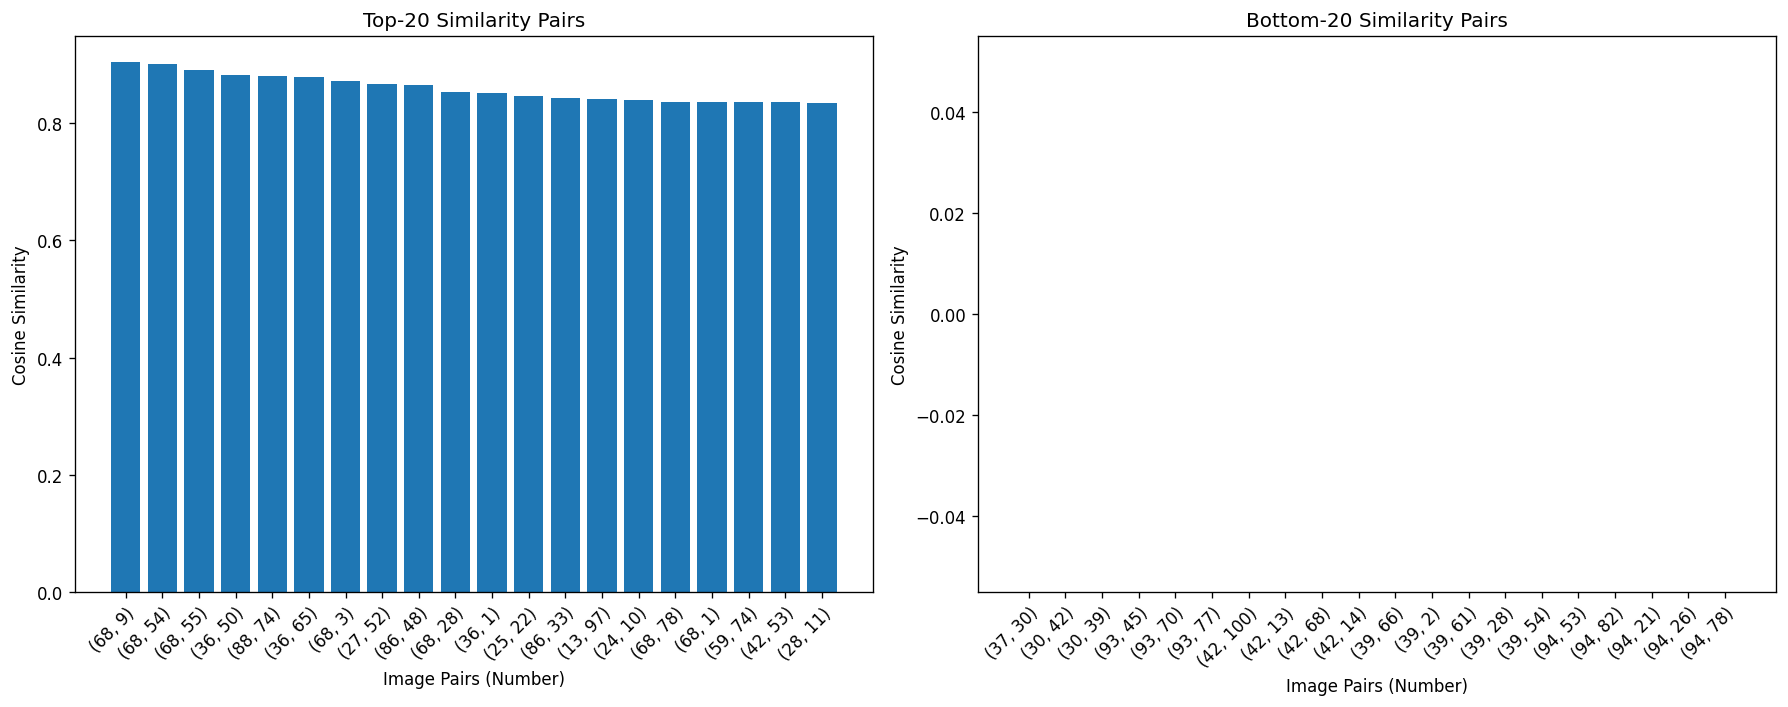

In [21]:
max_pairs_class1,min_pairs_class1=intra_category_similarity(donations_values_list1)

In [22]:
max_pairs_class1

[('dataset/n02105505/n02105505_68.jpg', 'dataset/n02105505/n02105505_9.jpg'),
 ('dataset/n02105505/n02105505_68.jpg', 'dataset/n02105505/n02105505_54.jpg'),
 ('dataset/n02105505/n02105505_68.jpg', 'dataset/n02105505/n02105505_55.jpg'),
 ('dataset/n02105505/n02105505_36.jpg', 'dataset/n02105505/n02105505_50.jpg'),
 ('dataset/n02105505/n02105505_88.jpg', 'dataset/n02105505/n02105505_74.jpg'),
 ('dataset/n02105505/n02105505_36.jpg', 'dataset/n02105505/n02105505_65.jpg'),
 ('dataset/n02105505/n02105505_68.jpg', 'dataset/n02105505/n02105505_3.jpg'),
 ('dataset/n02105505/n02105505_27.jpg', 'dataset/n02105505/n02105505_52.jpg'),
 ('dataset/n02105505/n02105505_86.jpg', 'dataset/n02105505/n02105505_48.jpg'),
 ('dataset/n02105505/n02105505_68.jpg', 'dataset/n02105505/n02105505_28.jpg'),
 ('dataset/n02105505/n02105505_36.jpg', 'dataset/n02105505/n02105505_1.jpg'),
 ('dataset/n02105505/n02105505_25.jpg', 'dataset/n02105505/n02105505_22.jpg'),
 ('dataset/n02105505/n02105505_86.jpg', 'dataset/n02105

In [23]:
# plot_image_pairs(max_pairs_class1, n_rows=5, n_columns=2,figsize=(15, 10)) 

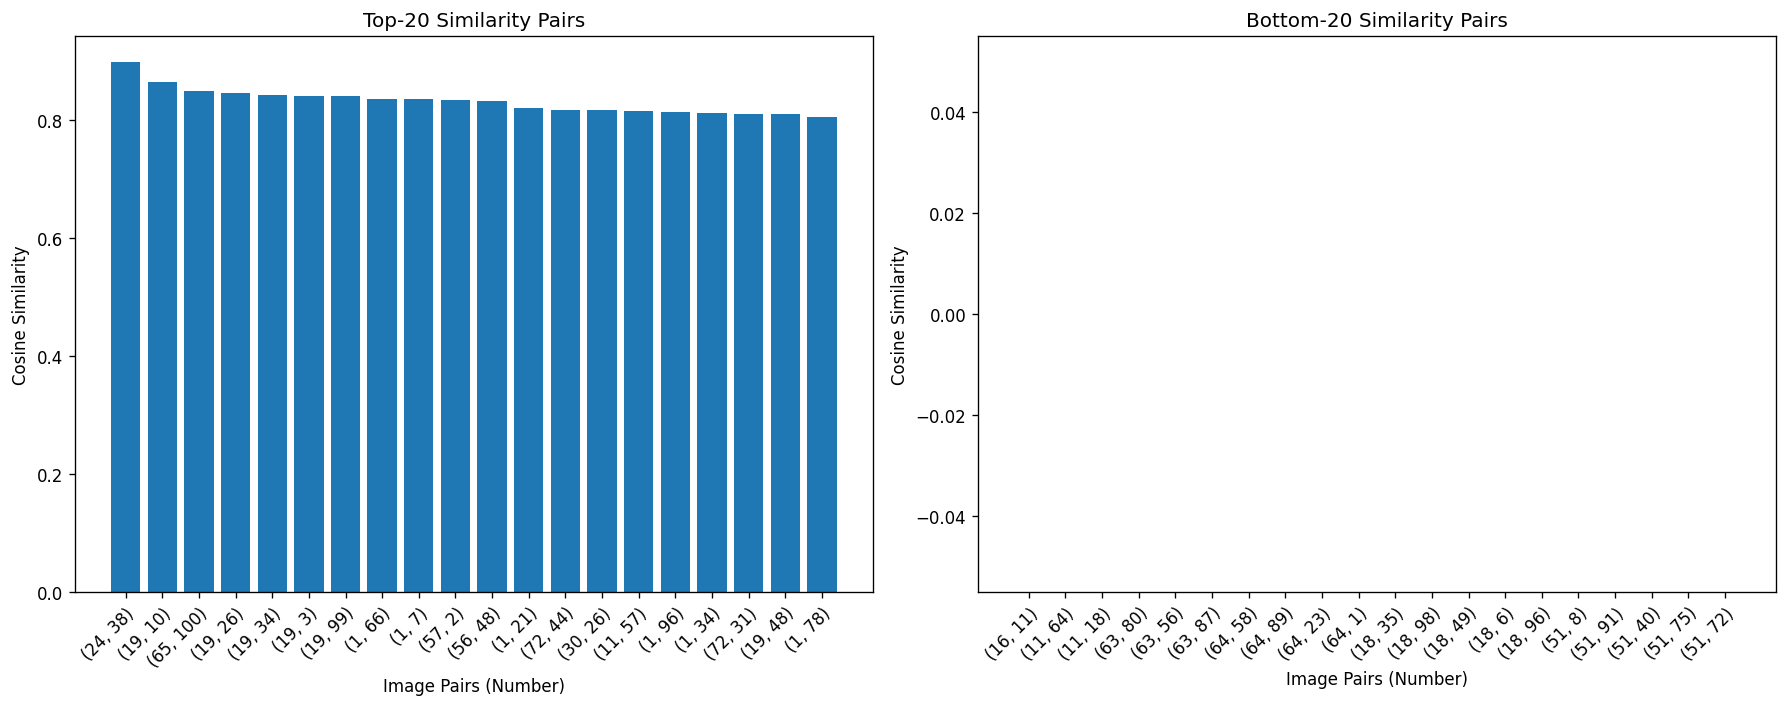

In [24]:
max_pairs_class2,min_pairs_class2=intra_category_similarity(donations_values_list2)

In [25]:
max_pairs_class2

[('dataset/n02101006/n02101006_24.jpg', 'dataset/n02101006/n02101006_38.jpg'),
 ('dataset/n02101006/n02101006_19.jpg', 'dataset/n02101006/n02101006_10.jpg'),
 ('dataset/n02101006/n02101006_65.jpg', 'dataset/n02101006/n02101006_100.jpg'),
 ('dataset/n02101006/n02101006_19.jpg', 'dataset/n02101006/n02101006_26.jpg'),
 ('dataset/n02101006/n02101006_19.jpg', 'dataset/n02101006/n02101006_34.jpg'),
 ('dataset/n02101006/n02101006_19.jpg', 'dataset/n02101006/n02101006_3.jpg'),
 ('dataset/n02101006/n02101006_19.jpg', 'dataset/n02101006/n02101006_99.jpg'),
 ('dataset/n02101006/n02101006_1.jpg', 'dataset/n02101006/n02101006_66.jpg'),
 ('dataset/n02101006/n02101006_1.jpg', 'dataset/n02101006/n02101006_7.jpg'),
 ('dataset/n02101006/n02101006_57.jpg', 'dataset/n02101006/n02101006_2.jpg'),
 ('dataset/n02101006/n02101006_56.jpg', 'dataset/n02101006/n02101006_48.jpg'),
 ('dataset/n02101006/n02101006_1.jpg', 'dataset/n02101006/n02101006_21.jpg'),
 ('dataset/n02101006/n02101006_72.jpg', 'dataset/n0210100

In [26]:
# plot_image_pairs(max_pairs_class2, n_rows=5, n_columns=2,figsize=(15, 10)) 

In [27]:
# intra_category_similarity(donations_values_list3)

In [28]:
# import numpy as np  
# import matplotlib.pyplot as plt  

# def cross_category_similarity(donations_values_list1, donations_values_list2, top_n=20):  
#     """  
#     分析两个类别间所有图片两两的余弦相似度，并返回相似度最大的和最小的样本对。  

#     Parameters:  
#         donations_values_list1 (list): 第一个类别的图片嵌入向量列表。  
#         donations_values_list2 (list): 第二个类别的图片嵌入向量列表。  
#         top_n (int, optional): 指定要返回和展示的样本对数。默认为20。  

#     Returns:  
#         dict: 包含max_similarity和min_similarity的结果。  
#     """  

#     # 初始化matplotlib的参数  
#     plt.rcParams['figure.dpi'] = 120  
#     plt.rcParams['font.size'] = 10  

#     # 计算两类之间的余弦相似度  
#     cross_similarity = []  
#     for i, vec1 in enumerate(donations_values_list1):  
#         for j, vec2 in enumerate(donations_values_list2):  
#             # 计算点积  
#             dot_product = np.dot(vec1, vec2)  
#             # 计算模长  
#             magnitude1 = np.linalg.norm(vec1)  
#             magnitude2 = np.linalg.norm(vec2)  
#             if magnitude1 == 0 or magnitude2 == 0:  
#                 similarity = 0.0  
#             else:  
#                 similarity = dot_product / (magnitude1 * magnitude2)  
#             cross_similarity.append({  
#                 'similarity': similarity,  
#                 'sample1_idx': i,  
#                 'sample2_idx': j  
#             })  

#     # 按相似度排序  
#     cross_similarity.sort(key=lambda x: x['similarity'], reverse=True)  

#     # 提取最大和最小的top_n  
#     max_similarity = cross_similarity[:top_n]  
#     min_similarity = cross_similarity[-top_n:]  

#     # 为可视化准备数据  
#     max_sim_values = [pair['similarity'] for pair in max_similarity]  
#     max_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in max_similarity]  

#     min_sim_values = [pair['similarity'] for pair in min_similarity]  
#     min_sim_indices = [f"({pair['sample1_idx']}, {pair['sample2_idx']})" for pair in min_similarity]  

#     # 绘制柱状图  
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  

#     # 最大相似度图  
#     ax1.bar(max_sim_indices, max_sim_values)  
#     ax1.set_title('Top-{} Similarity Pairs'.format(top_n))  
#     ax1.set_xlabel('Sample Pairs (Class1, Class2)')  
#     ax1.set_ylabel('Cosine Similarity')  
#     plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

#     # 最小相似度图  
#     ax2.bar(min_sim_indices, min_sim_values)  
#     ax2.set_title('Bottom-{} Similarity Pairs'.format(top_n))  
#     ax2.set_xlabel('Sample Pairs (Class1, Class2)')  
#     ax2.set_ylabel('Cosine Similarity')  
#     plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

#     plt.tight_layout()  
#     plt.show()  



In [29]:
def cross_category_similarity_optimized(donations_dict1, donations_dict2, top_n=20):  
    # 将嵌入向量转换为NumPy数组  
    img_paths1 = list(donations_dict1.keys())  
    vectors1 = np.array(list(donations_dict1.values()))  
    
    img_paths2 = list(donations_dict2.keys())  
    vectors2 = np.array(list(donations_dict2.values()))  
    
    # 计算所有图片对的点积  
    dot_products = np.dot(vectors1, vectors2.T)  
    
    # 计算模长  
    magnitudes1 = np.linalg.norm(vectors1, axis=1, keepdims=True)  
    magnitudes2 = np.linalg.norm(vectors2, axis=1)  
    
    # 计算余弦相似度  
    with np.errstate(divide='ignore', invalid='ignore'):  
        similarities = dot_products / (magnitudes1 * magnitudes2)  
    
    # 处理零向量导致的NaN  
    similarities = np.nan_to_num(similarities, 0.0)  
    
    # flatten为一维数组，并获取索引  
    similarities_flat = similarities.flatten()  
    indices = np.argsort(-similarities_flat)  
    
    max_indices = indices[:top_n]  
    min_indices = indices[-top_n:]  
    
    # 重新生成图片对信息  
    rows, cols = np.unravel_index(max_indices, similarities.shape)  
    max_similarity = []  
    for i, j in zip(rows, cols):  
        max_similarity.append({  
            'similarity': similarities[i, j],  
            'img_path1': img_paths1[i],  
            'img_path2': img_paths2[j]  
        })  
    
    rows_min, cols_min = np.unravel_index(min_indices, similarities.shape)  
    min_similarity = []  
    for i, j in zip(rows_min, cols_min):  
        min_similarity.append({  
            'similarity': similarities[i, j],  
            'img_path1': img_paths1[i],  
            'img_path2': img_paths2[j]  
        })  
    
    # 提取编号并生成标签  
    max_labels = [f"({extract_number_from_path(pair['img_path1'])}, {extract_number_from_path(pair['img_path2'])})"   
                  for pair in max_similarity]  
    min_labels = [f"({extract_number_from_path(pair['img_path1'])}, {extract_number_from_path(pair['img_path2'])})"   
                  for pair in min_similarity]  
    
    max_sim_values = [pair['similarity'] for pair in max_similarity]  
    min_sim_values = [pair['similarity'] for pair in min_similarity]  
    
    # 绘制图表  
    plt.figure(figsize=(15, 6))  
    
    ax1 = plt.subplot(1, 2, 1)  
    ax1.bar(max_labels, max_sim_values)  
    ax1.set_title(f'Top-{top_n} Similarity Pairs')  
    ax1.set_xlabel('Image Pairs (Class1, Class2)')  
    ax1.set_ylabel('Cosine Similarity')  
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  
    
    ax2 = plt.subplot(1, 2, 2)  
    ax2.bar(min_labels, min_sim_values)  
    ax2.set_title(f'Bottom-{top_n} Similarity Pairs')  
    ax2.set_xlabel('Image Pairs (Class1, Class2)')  
    ax2.set_ylabel('Cosine Similarity')  
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  
    
    plt.tight_layout()  
    plt.show()  
    # 提取图片路径对  
    max_img_pairs = [(pair['img_path1'], pair['img_path2']) for pair in max_similarity]  
    min_img_pairs = [(pair['img_path1'], pair['img_path2']) for pair in min_similarity]  
    
    # 返回相似度和图片对  
    return max_img_pairs, min_img_pairs


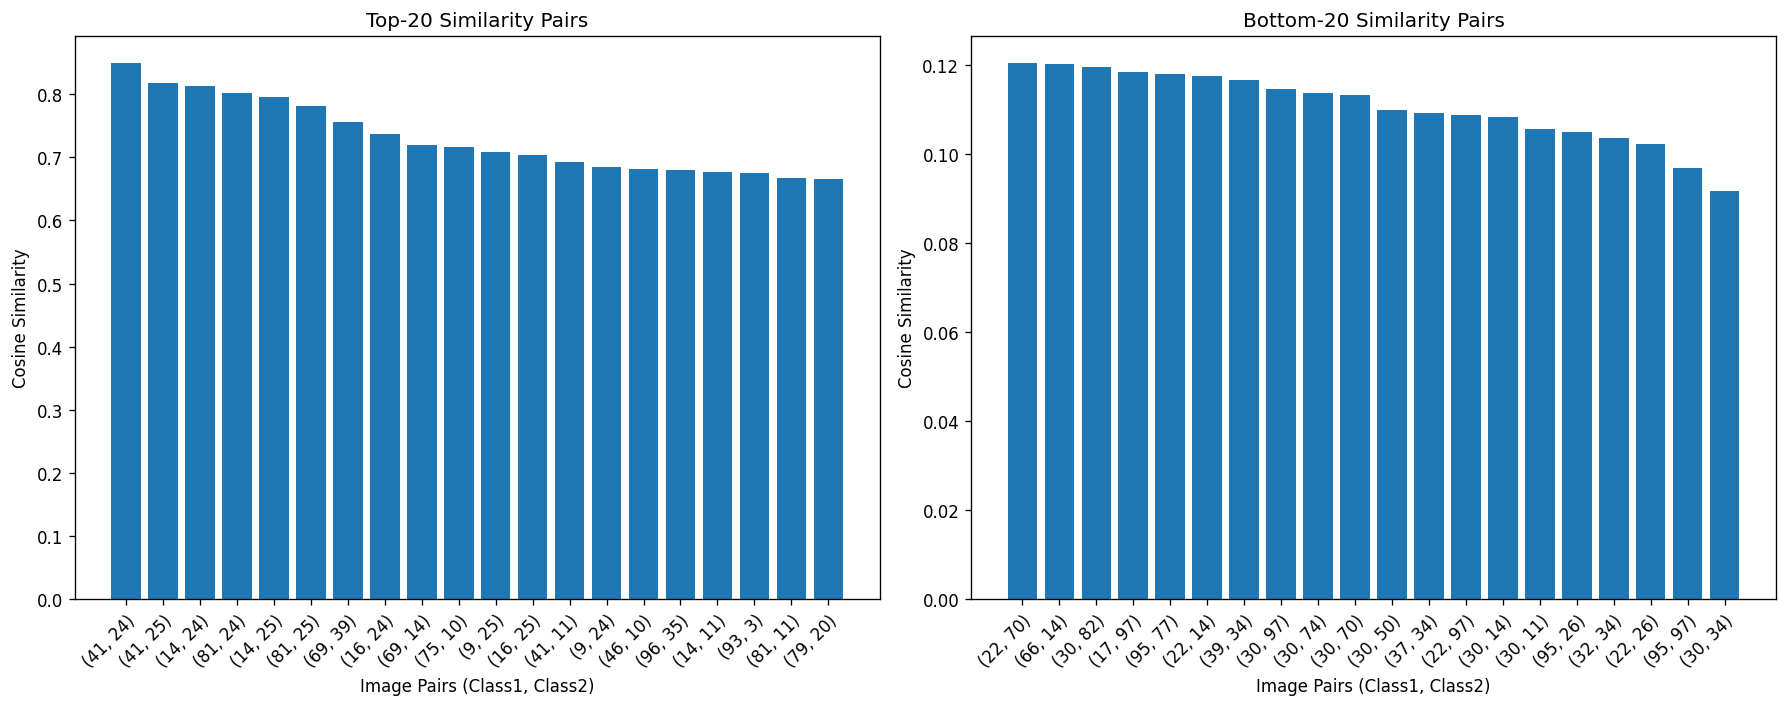

In [30]:
max_img_pairs, min_img_pairs=cross_category_similarity_optimized(donations_values_list1, donations_values_list2, top_n=20)

In [31]:
max_img_pairs

[('dataset/n02105505/n02105505_41.jpg', 'dataset/n02101006/n02101006_24.jpg'),
 ('dataset/n02105505/n02105505_41.jpg', 'dataset/n02101006/n02101006_25.jpg'),
 ('dataset/n02105505/n02105505_14.jpg', 'dataset/n02101006/n02101006_24.jpg'),
 ('dataset/n02105505/n02105505_81.jpg', 'dataset/n02101006/n02101006_24.jpg'),
 ('dataset/n02105505/n02105505_14.jpg', 'dataset/n02101006/n02101006_25.jpg'),
 ('dataset/n02105505/n02105505_81.jpg', 'dataset/n02101006/n02101006_25.jpg'),
 ('dataset/n02105505/n02105505_69.jpg', 'dataset/n02101006/n02101006_39.jpg'),
 ('dataset/n02105505/n02105505_16.jpg', 'dataset/n02101006/n02101006_24.jpg'),
 ('dataset/n02105505/n02105505_69.jpg', 'dataset/n02101006/n02101006_14.jpg'),
 ('dataset/n02105505/n02105505_75.jpg', 'dataset/n02101006/n02101006_10.jpg'),
 ('dataset/n02105505/n02105505_9.jpg', 'dataset/n02101006/n02101006_25.jpg'),
 ('dataset/n02105505/n02105505_16.jpg', 'dataset/n02101006/n02101006_25.jpg'),
 ('dataset/n02105505/n02105505_41.jpg', 'dataset/n021

In [32]:
# 使用示例  
# plot_image_pairs(max_img_pairs, n_rows=5, n_columns=2,figsize=(15, 10)) 

In [33]:
# plot_image_pairs(min_img_pairs, n_rows=5, n_columns=2,figsize=(15, 10))

In [34]:
# cross_category_similarity(donations_values_list1, donations_values_list3, top_n=20)

In [35]:
# cross_category_similarity(donations_values_list2, donations_values_list3, top_n=20)

In [36]:
# import torch  
# import matplotlib.pyplot as plt  

# def compute_channel_similarities(donations_values_list1, donations_values_list2):  
#     """  
#     计算两个类别之间的样本在每个channel上的平均相似度。  

#     Parameters:  
#         donations_values_list1 (list): 第一个类别的样本列表，每个样本为形状 (2048,) 的 PyTorch tensor。  
#         donations_values_list2 (list): 第二个类别的样本列表，每个样本为形状 (2048,) 的 PyTorch tensor。  

#     Returns:  
#         list: 包含每个channel的平均相似度的列表。  
#     """  
#     num_samples1 = len(donations_values_list1)  
#     num_samples2 = len(donations_values_list2)  
#     num_channels = donations_values_list1[0].shape[0]  # 获取channel数量（假设为2048）  

#     # 初始化每个channel的总和为0  
#     channel_sums = torch.zeros(num_channels)  

#     for i in range(num_samples1):  
#         for j in range(num_samples2):  
#             # 计算绝对差异  
#             abs_diff = torch.abs(donations_values_list1[i] - donations_values_list2[j])  
            
#             # 计算归一化因子（绝对差异的总和）  
#             sum_diff = torch.sum(abs_diff)  
            
#             # 避免除以零的情况  
#             normalized_diff = abs_diff / (sum_diff + 1e-8)  
            
#             # 将归一化后的差异累加到对应的channel  
#             channel_sums += normalized_diff  

#     # 计算每个channel的平均相似度  
#     total_pairs = num_samples1 * num_samples2  # 样本对的总数  
#     channel_means = channel_sums / total_pairs  

#     return channel_means  


# def calculate_ylim(channel_means, buffer=0.0):  
#     """  
#     计算y轴范围，固定在0到0.2之间。  
#     """  
#     ymin = 0.0  
#     ymax = 0.2  
#     return (ymin, ymax)  

# def plot_channel_similarities(channel_means, num_channels=2048, ylim=None):  
#     """  
#     绘制每个channel的平均相似度的柱状图，纵坐标范围固定为0-0.2。  
    
#     Parameters:  
#         channel_means (list): 包含每个channel的平均相似度的列表。  
#         num_channels (int): channel的数量。默认为2048。  
#         ylim (tuple, optional): 指定y轴的范围（ymin, ymax）。如果未提供，函数会使用默认范围(0, 0.2)。  
        
#     Returns:  
#         tuple: y轴范围 (ymin, ymax)  
#     """  
#     plt.figure(figsize=(12, 6))  
#     plt.bar(range(num_channels), channel_means, color='blue')  
#     plt.title('Average Similarity Across Channels')  
#     plt.ylabel('Normalized Similarity')  
    
#     # 如果未提供ylim，使用默认的0-0.2范围  
#     if ylim is None:  
#         ylim = calculate_ylim(channel_means)  
#     plt.ylim(ylim)  
    
#     # 移除x轴标签和刻度  
#     plt.xticks([])  
#     plt.xlabel('')  
    
#     plt.tight_layout()  
#     plt.show() 



In [37]:
# def cross_category_average_similarity(donations_values_list1, donations_values_list2):
#     # 计算每个channel的平均相似度  
#     channel_means = compute_channel_similarities(donations_values_list1, donations_values_list2)  
#     # 绘制柱状图  
#     plot_channel_similarities(channel_means)  

In [38]:
# cross_category_average_similarity(donations_values_list1, donations_values_list2)